###Q1

Test Accuracy after 200 rounds: 99.33%


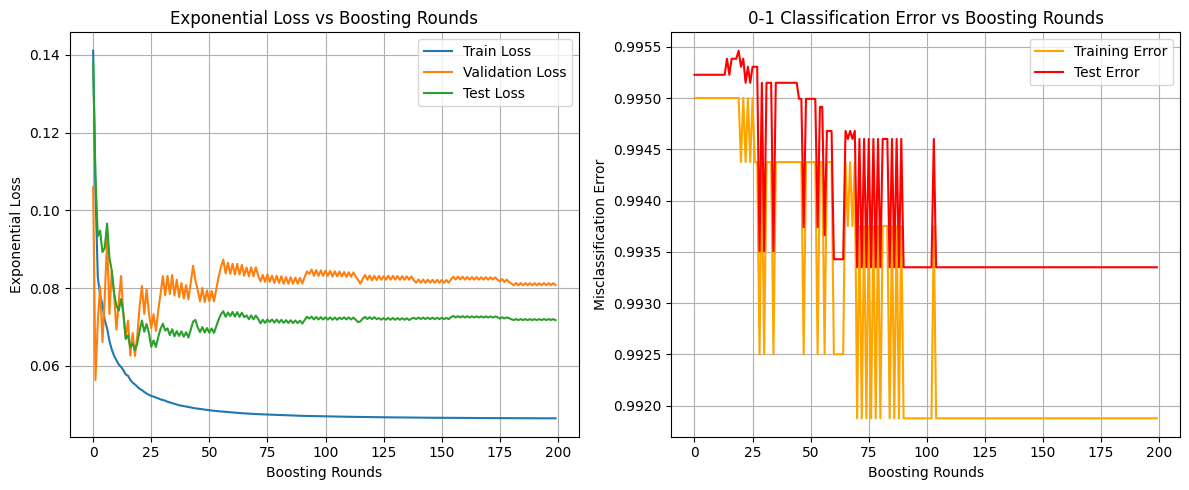

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(int)

mask = (y == 0) | (y == 1)
X, y = X[mask], y[mask]

X0, y0 = X[y == 0][:1000], y[y == 0][:1000]
X1, y1 = X[y == 1][:1000], y[y == 1][:1000]
X_train = np.vstack((X0, X1))
y_train = np.hstack((y0, y1))

X_test = np.vstack((X[y == 0][1000:], X[y == 1][1000:]))
y_test = np.hstack((y[y == 0][1000:], y[y == 1][1000:]))

# Converting labels to {-1, +1}
y_train = np.where(y_train == 0, -1, 1)
y_test = np.where(y_test == 0, -1, 1)

# PCA to 5 dimensions
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

X_train_pca, X_val_pca, y_train, y_val = train_test_split(X_train_pca, y_train, test_size=0.2, random_state=42)

def best_stump(X, y, sample_weights):
    n_samples, n_features = X.shape
    best_feature, best_threshold, best_polarity = None, None, 1
    min_error = float('inf')

    for feature in range(n_features):
        values = X[:, feature]
        thresholds = np.linspace(values.min(), values.max(), 5)[1:-1]  # 3 cuts
        for threshold in thresholds:
            for polarity in [1, -1]:
                preds = np.ones(n_samples)
                preds[polarity * values < polarity * threshold] = -1
                error = np.sum(sample_weights[preds != y])
                if error < min_error:
                    best_feature = feature
                    best_threshold = threshold
                    best_polarity = polarity
                    min_error = error
    return best_feature, best_threshold, best_polarity, min_error

def predict(X, alphas, stumps):
    total = np.zeros(X.shape[0])
    for alpha, (feat, thresh, pol) in zip(alphas, stumps):
        pred = np.ones(X.shape[0])
        pred[pol * X[:, feat] < pol * thresh] = -1
        total += alpha * pred
    return total
def sign_fix(x):
    out = np.sign(x)
    out[out == 0] = -1
    return out

T = 200
alphas = []
stumps = []
train_loss, val_loss, test_loss = [], [], []
train_error, test_error = [], []

n_train = len(y_train)
weights = np.ones(n_train) / n_train

for t in range(T):
    feat, thresh, pol, err = best_stump(X_train_pca, y_train, weights)
    eps = 1e-10  # avoid division by zero
    alpha = 0.5 * np.log((1 - err + eps) / (err + eps))

    preds = np.ones(n_train)
    preds[pol * X_train_pca[:, feat] < pol * thresh] = -1

    weights *= np.exp(-alpha * y_train * preds)
    weights /= weights.sum()

    alphas.append(alpha)
    stumps.append((feat, thresh, pol))

    train_pred = predict(X_train_pca, alphas, stumps)
    val_pred = predict(X_val_pca, alphas, stumps)
    test_pred = predict(X_test_pca, alphas, stumps)

    train_loss.append(np.mean(np.exp(-y_train * train_pred)))
    val_loss.append(np.mean(np.exp(-y_val * val_pred)))
    test_loss.append(np.mean(np.exp(-y_test * test_pred)))

    train_error.append(np.mean(sign_fix(train_pred) == y_train))
    test_error.append(np.mean(sign_fix(test_pred) == y_test))

test_acc = accuracy_score(y_test, np.sign(test_pred))
print(f"Test Accuracy after {T} rounds: {test_acc * 100:.2f}%")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.plot(test_loss, label="Test Loss")
plt.title("Exponential Loss vs Boosting Rounds")
plt.xlabel("Boosting Rounds")
plt.ylabel("Exponential Loss")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_error, color='orange', label="Training Error")
plt.plot(test_error, color='red', label="Test Error")
plt.title("0-1 Classification Error vs Boosting Rounds")
plt.xlabel("Boosting Rounds")
plt.ylabel("Misclassification Error")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

->Validation/test loss decrease and then increase means model is overfitting

---


->even when classification 0-1 error plateaus the exponential loss keeps on decreasing




##Q2

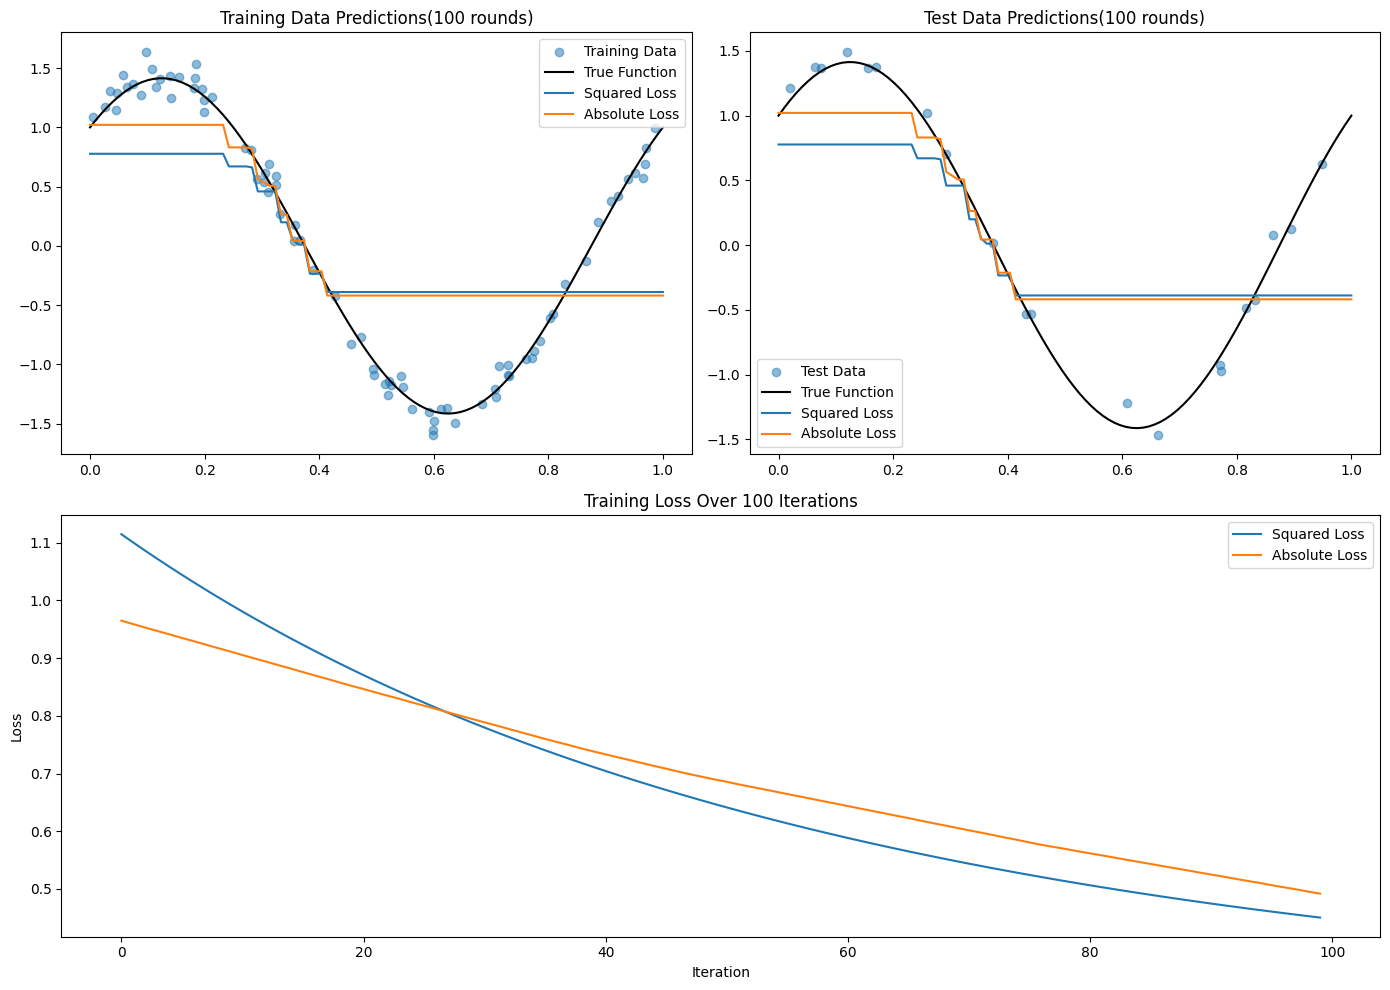

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor


np.random.seed(42)
x = np.random.uniform(0, 1, 100)
y = np.sin(2 * np.pi * x) + np.cos(2 * np.pi * x) + np.random.normal(0, 0.1, 100)## N(0, 0.01) var=0.01, std dev=0.1


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


x_train = x_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)


class GradientBoosting:
    def __init__(self, loss='squared', n_estimators=100, learning_rate=0.01, max_depth=1):
        self.loss = loss
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):

        self.initial_pred = np.mean(y)
        current_pred = np.full_like(y, self.initial_pred)

        for _ in range(self.n_estimators):

            if self.loss == 'squared':
                residuals = y - current_pred
            elif self.loss == 'absolute':
                residuals = np.sign(y - current_pred)


            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)


            current_pred += self.learning_rate * tree.predict(X)
            self.trees.append(tree)

    def predict(self, X):
        pred = np.full(X.shape[0], self.initial_pred)
        for tree in self.trees:
            pred += self.learning_rate * tree.predict(X)
        return pred


models = {
    'Squared Loss': GradientBoosting(loss='squared', n_estimators=100, learning_rate=0.01),
    'Absolute Loss': GradientBoosting(loss='absolute', n_estimators=100, learning_rate=0.01)
}

for name, model in models.items():
    model.fit(x_train, y_train)


plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
x_plot = np.linspace(0, 1, 100).reshape(-1, 1)
plt.scatter(x_train, y_train, label='Training Data', alpha=0.5)
plt.plot(x_plot, np.sin(2*np.pi*x_plot) + np.cos(2*np.pi*x_plot), 'k-', label='True Function')
for name, model in models.items():
    plt.plot(x_plot, model.predict(x_plot), label=name)
plt.title('Training Data Predictions(100 rounds)')
plt.legend()


plt.subplot(2, 2, 2)
plt.scatter(x_test, y_test, label='Test Data', alpha=0.5)
plt.plot(x_plot, np.sin(2*np.pi*x_plot) + np.cos(2*np.pi*x_plot), 'k-', label='True Function')
for name, model in models.items():
    plt.plot(x_plot, model.predict(x_plot), label=name)
plt.title('Test Data Predictions(100 rounds)')
plt.legend()


plt.subplot(2, 1, 2)
for name, model in models.items():
    losses = []
    current_pred = np.full_like(y_train, np.mean(y_train))
    for tree in model.trees:
        if model.loss == 'squared':
            current_pred += model.learning_rate * tree.predict(x_train)
            loss = np.mean((y_train - current_pred)**2)
        elif model.loss == 'absolute':
            current_pred += model.learning_rate * tree.predict(x_train)
            loss = np.mean(np.abs(y_train - current_pred))
        losses.append(loss)
    plt.plot(losses, label=name)
plt.title('Training Loss Over 100 Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

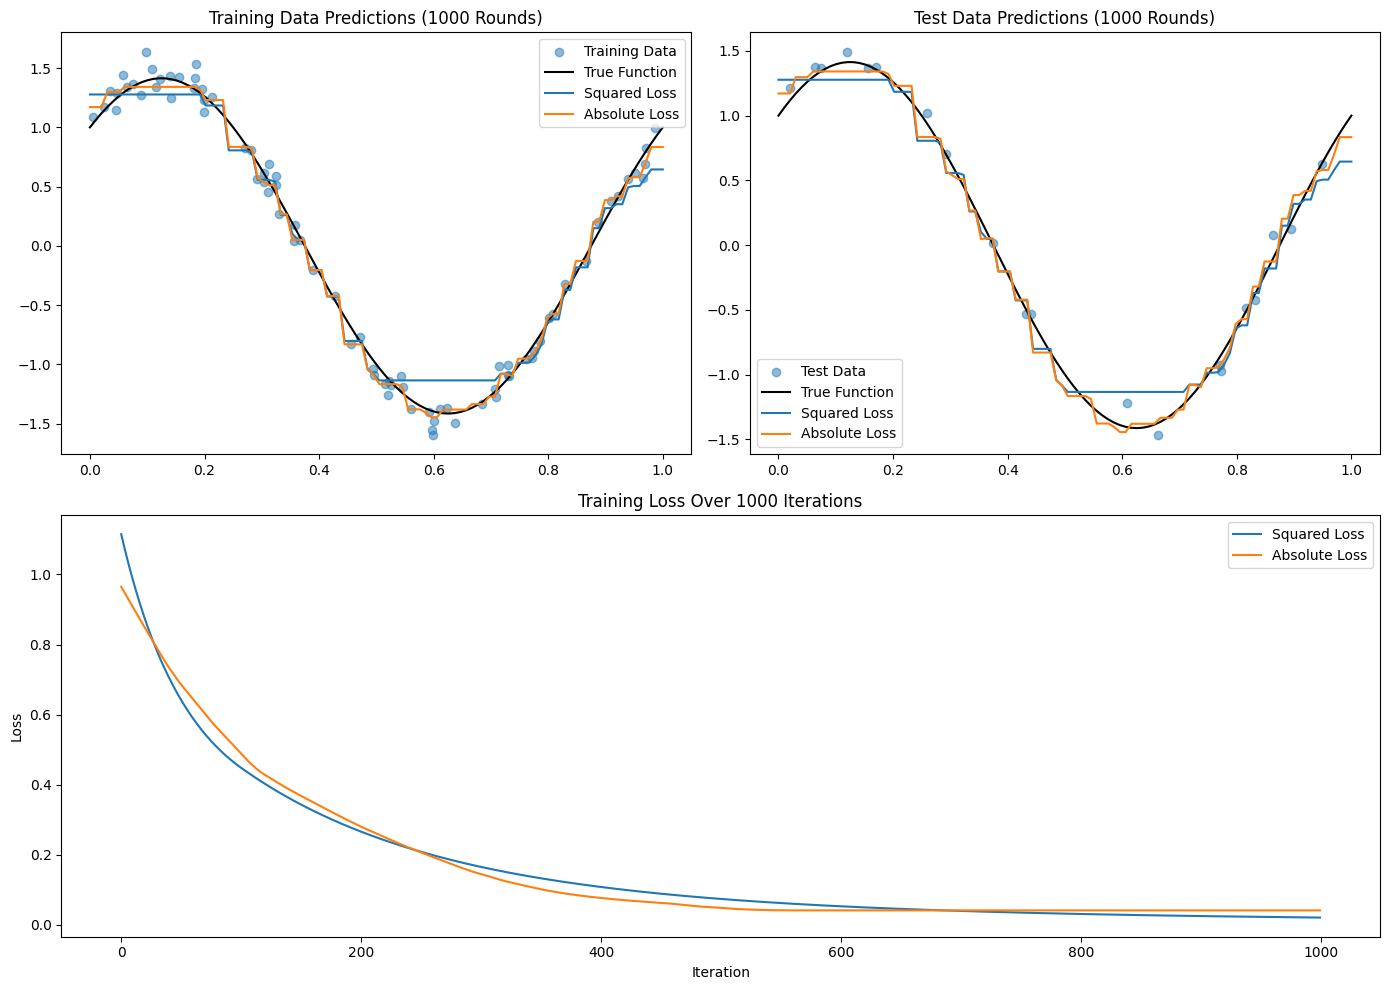

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor


np.random.seed(42)
x = np.random.uniform(0, 1, 100)
y = np.sin(2 * np.pi * x) + np.cos(2 * np.pi * x) +  np.random.normal(0, 0.1, 100)## N(0, 0.01) var=0.01, std dev=0.1

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train = x_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)

class GradientBoosting:
    def __init__(self, loss='squared', n_estimators=1000, learning_rate=0.01, max_depth=1):
        self.loss = loss
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        self.initial_pred = np.mean(y)
        current_pred = np.full_like(y, self.initial_pred)

        for _ in range(self.n_estimators):
            if self.loss == 'squared':
                residuals = y - current_pred
            elif self.loss == 'absolute':
                residuals = np.sign(y - current_pred)

            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)

            current_pred += self.learning_rate * tree.predict(X)
            self.trees.append(tree)

    def predict(self, X):
        pred = np.full(X.shape[0], self.initial_pred)
        for tree in self.trees:
            pred += self.learning_rate * tree.predict(X)
        return pred

models = {
    'Squared Loss': GradientBoosting(loss='squared', n_estimators=1000, learning_rate=0.01),
    'Absolute Loss': GradientBoosting(loss='absolute', n_estimators=1000, learning_rate=0.01)
}

for name, model in models.items():
    model.fit(x_train, y_train)

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
x_plot = np.linspace(0, 1, 100).reshape(-1, 1)
plt.scatter(x_train, y_train, label='Training Data', alpha=0.5)
plt.plot(x_plot, np.sin(2*np.pi*x_plot) + np.cos(2*np.pi*x_plot), 'k-', label='True Function')
for name, model in models.items():
    plt.plot(x_plot, model.predict(x_plot), label=name)
plt.title('Training Data Predictions (1000 Rounds)')
plt.legend()

plt.subplot(2, 2, 2)
plt.scatter(x_test, y_test, label='Test Data', alpha=0.5)
plt.plot(x_plot, np.sin(2*np.pi*x_plot) + np.cos(2*np.pi*x_plot), 'k-', label='True Function')
for name, model in models.items():
    plt.plot(x_plot, model.predict(x_plot), label=name)
plt.title('Test Data Predictions (1000 Rounds)')
plt.legend()

plt.subplot(2, 1, 2)
for name, model in models.items():
    losses = []
    current_pred = np.full_like(y_train, np.mean(y_train))
    for tree in model.trees:
        if model.loss == 'squared':
            current_pred += model.learning_rate * tree.predict(x_train)
            loss = np.mean((y_train - current_pred)**2)
        elif model.loss == 'absolute':
            current_pred += model.learning_rate * tree.predict(x_train)
            loss = np.mean(np.abs(y_train - current_pred))
        losses.append(loss)
    plt.plot(losses, label=name)
plt.title('Training Loss Over 1000 Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Absolute loss slightly better in this case, as it is less sensitive to outliers.

###Q3

1000 number of epochs

Epoch 0: Train MSE = 0.5387, Test MSE = 0.2777
Epoch 50: Train MSE = 0.1285, Test MSE = 0.1654
Epoch 100: Train MSE = 0.0395, Test MSE = 0.1060
Epoch 150: Train MSE = 0.0186, Test MSE = 0.1066
Epoch 200: Train MSE = 0.0144, Test MSE = 0.1127
Epoch 250: Train MSE = 0.0127, Test MSE = 0.1163
Epoch 300: Train MSE = 0.0114, Test MSE = 0.1186
Epoch 350: Train MSE = 0.0105, Test MSE = 0.1202
Epoch 400: Train MSE = 0.0096, Test MSE = 0.1215
Epoch 450: Train MSE = 0.0090, Test MSE = 0.1227
Epoch 500: Train MSE = 0.0084, Test MSE = 0.1237
Epoch 550: Train MSE = 0.0079, Test MSE = 0.1247
Epoch 600: Train MSE = 0.0074, Test MSE = 0.1256
Epoch 650: Train MSE = 0.0070, Test MSE = 0.1264
Epoch 700: Train MSE = 0.0067, Test MSE = 0.1271
Epoch 750: Train MSE = 0.0063, Test MSE = 0.1278
Epoch 800: Train MSE = 0.0061, Test MSE = 0.1285
Epoch 850: Train MSE = 0.0058, Test MSE = 0.1291
Epoch 900: Train MSE = 0.0056, Test MSE = 0.1297
Epoch 950: Train MSE = 0.0053, Test MSE = 0.1302

Final Test MSE: 0.1307

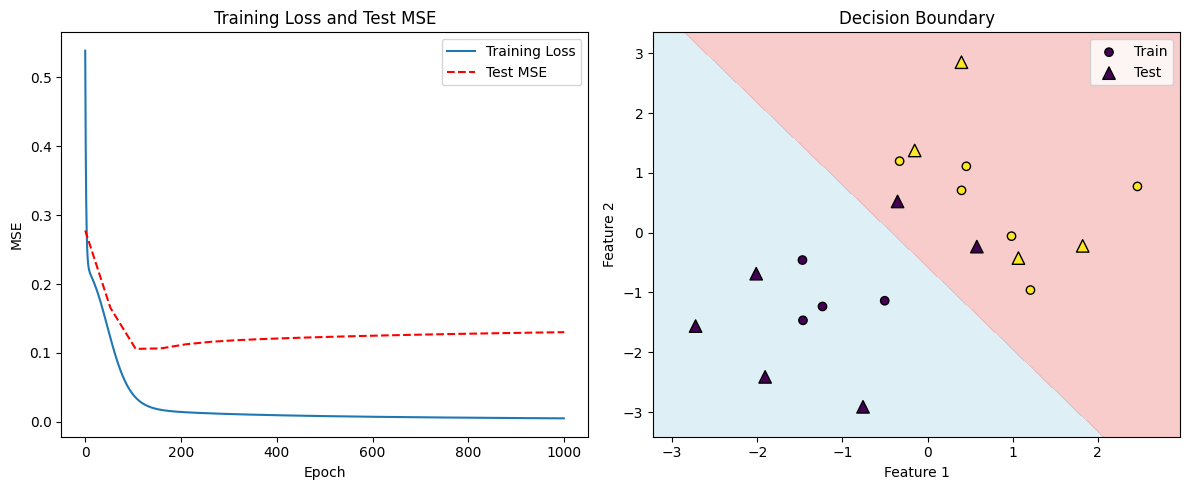

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Activation functions
def sigmoid(z):
    """Sigmoid activation function"""
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    """Derivative of sigmoid function"""
    s = sigmoid(z)
    return s * (1 - s)

# Generate synthetic dataset
np.random.seed(42)
n_samples_per_class = 10

# Class distributions
X0 = np.random.multivariate_normal(mean=[-1, -1], cov=np.eye(2), size=n_samples_per_class)
X1 = np.random.multivariate_normal(mean=[1, 1], cov=np.eye(2), size=n_samples_per_class)

# Combine and shuffle
X = np.vstack([X0, X1])
y = np.vstack([np.zeros((n_samples_per_class, 1)), np.ones((n_samples_per_class, 1))])
indices = np.random.permutation(len(X))
X, y = X[indices], y[indices]

# Train-test split (50-50)
split = len(X) // 2
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Initialize parameters
np.random.seed(0)
W1 = np.random.randn(2, 1) * 0.1  # Input to hidden weights
b1 = np.zeros(1)                   # Hidden layer bias
W2 = np.random.randn(1, 1) * 0.1   # Hidden to output weights
b2 = np.zeros(1)                   # Output bias

# Training parameters
lr = 0.1
epochs = 1000
loss_history = []
test_mse_history = []

# Training loop
for epoch in range(epochs):
    epoch_loss = 0

    # Mini-batch gradient descent (using all training samples)
    # Forward pass
    z1 = np.dot(X_train, W1) + b1
    a1 = sigmoid(z1)
    z2 = np.dot(a1, W2) + b2
    y_pred = z2

    # Compute loss (MSE)
    loss = np.mean((y_pred - y_train) ** 2)
    epoch_loss = loss

    # Backward pass
    dL_dy = 2 * (y_pred - y_train) / len(X_train)

    # Output layer gradients
    dW2 = np.dot(a1.T, dL_dy)
    db2 = np.sum(dL_dy, axis=0)

    # Hidden layer gradients
    da1 = np.dot(dL_dy, W2.T)
    dz1 = da1 * sigmoid_derivative(z1)
    dW1 = np.dot(X_train.T, dz1)
    db1 = np.sum(dz1, axis=0)

    # Update parameters
    W2 -= lr * dW2
    b2 -= lr * db2
    W1 -= lr * dW1
    b1 -= lr * db1

    # Track progress
    loss_history.append(epoch_loss)

    # Calculate test MSE every 50 epochs
    if epoch % 50 == 0:
        test_pred = predict(X_test)
        test_mse = np.mean((test_pred - y_test) ** 2)
        test_mse_history.append(test_mse)
        print(f"Epoch {epoch}: Train MSE = {epoch_loss:.4f}, Test MSE = {test_mse:.4f}")

# Final evaluation
def predict(X):
    """Make predictions using trained network"""
    z1 = np.dot(X, W1) + b1
    a1 = sigmoid(z1)
    z2 = np.dot(a1, W2) + b2
    return z2

y_pred_test = predict(X_test)
final_mse = np.mean((y_pred_test - y_test) ** 2)
print(f"\nFinal Test MSE: {final_mse:.4f}")

# Visualization
plt.figure(figsize=(12, 5))

# Plot loss history
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Training Loss')
plt.plot(np.linspace(0, epochs, len(test_mse_history)), test_mse_history, 'r--', label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training Loss and Test MSE')
plt.legend()

# Plot decision boundary
plt.subplot(1, 2, 2)
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
probs = predict(grid).reshape(xx.shape)

plt.contourf(xx, yy, probs, levels=[-float('inf'), 0.5, float('inf')],
             colors=['lightblue', 'lightcoral'], alpha=0.4)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train.flatten(),
            edgecolor='k', marker='o', label='Train')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test.flatten(),
            edgecolor='k', marker='^', s=80, label='Test')
plt.title('Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.tight_layout()
plt.show()

150 number of epochs

Epoch 0: Train MSE = 0.5387, Test MSE = 0.2777
Epoch 10: Train MSE = 0.2159, Test MSE = 0.2446
Epoch 20: Train MSE = 0.1991, Test MSE = 0.2347
Epoch 30: Train MSE = 0.1787, Test MSE = 0.2134
Epoch 40: Train MSE = 0.1544, Test MSE = 0.1891
Epoch 50: Train MSE = 0.1285, Test MSE = 0.1654
Epoch 60: Train MSE = 0.1036, Test MSE = 0.1448
Epoch 70: Train MSE = 0.0817, Test MSE = 0.1287
Epoch 80: Train MSE = 0.0637, Test MSE = 0.1173
Epoch 90: Train MSE = 0.0498, Test MSE = 0.1101
Epoch 100: Train MSE = 0.0395, Test MSE = 0.1060
Epoch 110: Train MSE = 0.0321, Test MSE = 0.1041

Final Test MSE: 0.1038


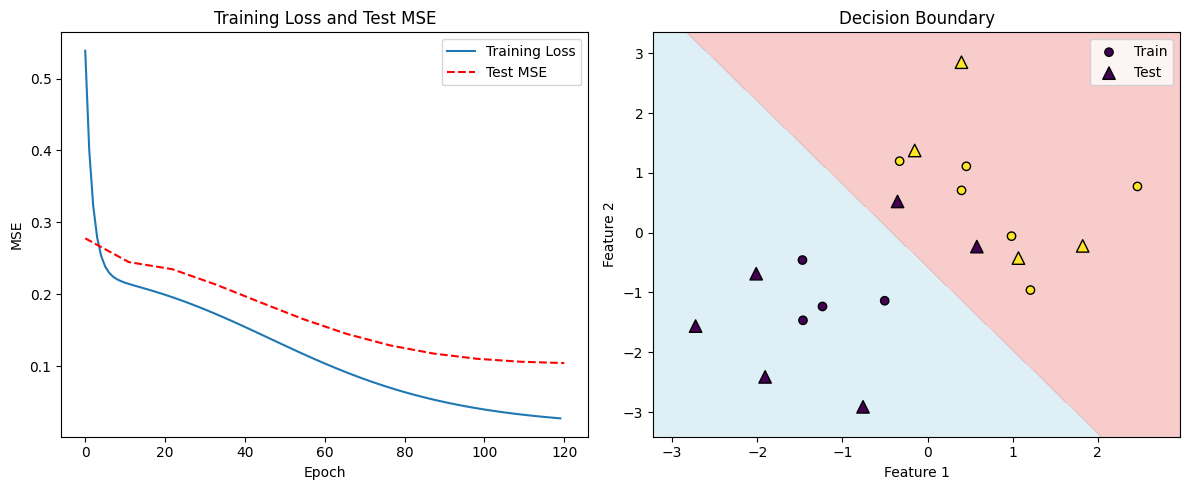

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Activation functions
def sigmoid(z):
    """Sigmoid activation function"""
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    """Derivative of sigmoid function"""
    s = sigmoid(z)
    return s * (1 - s)

# Generate synthetic dataset
np.random.seed(42)
n_samples_per_class = 10

# Class distributions
X0 = np.random.multivariate_normal(mean=[-1, -1], cov=np.eye(2), size=n_samples_per_class)
X1 = np.random.multivariate_normal(mean=[1, 1], cov=np.eye(2), size=n_samples_per_class)

# Combine and shuffle
X = np.vstack([X0, X1])
y = np.vstack([np.zeros((n_samples_per_class, 1)), np.ones((n_samples_per_class, 1))])
indices = np.random.permutation(len(X))
X, y = X[indices], y[indices]

# Train-test split (50-50)
split = len(X) // 2
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Initialize parameters
np.random.seed(0)
W1 = np.random.randn(2, 1) * 0.1  # Input to hidden weights
b1 = np.zeros(1)                   # Hidden layer bias
W2 = np.random.randn(1, 1) * 0.1   # Hidden to output weights
b2 = np.zeros(1)                   # Output bias

# Training parameters
lr = 0.1
epochs = 120
loss_history = []
test_mse_history = []

# Training loop
for epoch in range(epochs):
    epoch_loss = 0

    # Mini-batch gradient descent (using all training samples)
    # Forward pass
    z1 = np.dot(X_train, W1) + b1
    a1 = sigmoid(z1)
    z2 = np.dot(a1, W2) + b2
    y_pred = z2

    # Compute loss (MSE)
    loss = np.mean((y_pred - y_train) ** 2)
    epoch_loss = loss

    # Backward pass
    dL_dy = 2 * (y_pred - y_train) / len(X_train)

    # Output layer gradients
    dW2 = np.dot(a1.T, dL_dy)
    db2 = np.sum(dL_dy, axis=0)

    # Hidden layer gradients
    da1 = np.dot(dL_dy, W2.T)
    dz1 = da1 * sigmoid_derivative(z1)
    dW1 = np.dot(X_train.T, dz1)
    db1 = np.sum(dz1, axis=0)

    # Update parameters
    W2 -= lr * dW2
    b2 -= lr * db2
    W1 -= lr * dW1
    b1 -= lr * db1

    # Track progress
    loss_history.append(epoch_loss)

    # Calculate test MSE every 50 epochs
    if epoch%10==0 :
        test_pred = predict(X_test)
        test_mse = np.mean((test_pred - y_test) ** 2)
        test_mse_history.append(test_mse)
        print(f"Epoch {epoch}: Train MSE = {epoch_loss:.4f}, Test MSE = {test_mse:.4f}")

# Final evaluation
def predict(X):
    """Make predictions using trained network"""
    z1 = np.dot(X, W1) + b1
    a1 = sigmoid(z1)
    z2 = np.dot(a1, W2) + b2
    return z2

y_pred_test = predict(X_test)
final_mse = np.mean((y_pred_test - y_test) ** 2)
print(f"\nFinal Test MSE: {final_mse:.4f}")

# Visualization
plt.figure(figsize=(12, 5))

# Plot loss history
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Training Loss')
plt.plot(np.linspace(0, epochs, len(test_mse_history)), test_mse_history, 'r--', label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training Loss and Test MSE')
plt.legend()

# Plot decision boundary
plt.subplot(1, 2, 2)
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
probs = predict(grid).reshape(xx.shape)

plt.contourf(xx, yy, probs, levels=[-float('inf'), 0.5, float('inf')],
             colors=['lightblue', 'lightcoral'], alpha=0.4)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train.flatten(),
            edgecolor='k', marker='o', label='Train')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test.flatten(),
            edgecolor='k', marker='^', s=80, label='Test')
plt.title('Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.tight_layout()
plt.show()

no overfitting with 120 epochs(less than 150 epochs are resulting in decrease in test Mse)